## Sentiment Analysis across Unique TF-IDF Terms
Gulliver Wutz

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('display.max_colwidth', 500)

In [2]:
reddit_posts = pd.read_csv('C:/Users/wutzg/Desktop/Master Thesis/Artifacts/Datasets/reddit_posts_sentiment_2.csv')
reddit_posts.columns

Index(['Subreddit', 'Title', 'ID', 'Full ID', 'Author', 'URL', 'Is Self-post',
       'Score', 'Comment Count', 'Created CEST', 'Collected CEST',
       'Updated CEST', 'Content', 'Patch', 'BERT-BASE Title Sentiment',
       'BERT-BASE Content Sentiment', 'RoBERTa Title Sentiment',
       'RoBERTa Content Sentiment'],
      dtype='object')

In [26]:
unique_tfidf = pd.read_csv('unique_tf_idf_terms.csv', sep=';')
len(unique_tfidf)
unique_tfidf

,Patch,Unique Terms
0,14.1,"hydra, crit, lethality, far, great, armor, gives"
1,14.2,buff
2,14.3,"ve, thanks, tips, change"
3,14.4,patch
4,14.5,"looking, eq, eqeq, tell"
5,14.6,shield
6,14.7,"wave, slow, old"
7,14.8,"bot, wanted, instead"


In [4]:
post_contents_df = reddit_posts[(reddit_posts['Patch'] != 0)].copy()
post_contents_df.fillna(" NO TXT ", inplace=True)
post_contents_df.loc[:, 'Full Content'] = post_contents_df['Title'] + ' ' + post_contents_df['Content']

In [5]:
def find_word_in_text(text, words):
    for word in words:
        if word in text:
            return word
    return "NO COMMON TERM"

split_words = unique_tfidf['Unique Terms'].str.split(',')
unique_tfidf_lst = [word for sublist in split_words for word in sublist]
unique_tfidf_lst = [s.replace(" ", "") for s in unique_tfidf_lst]
unique_tfidf_lst = [' ' + word + ' ' for word in unique_tfidf_lst]
unique_tfidf_lst.reverse()
unique_tfidf_lst[unique_tfidf_lst.index(' eqeq ')] = 'eqeq'

post_contents_df['Unique Term'] = post_contents_df['Full Content'].apply(lambda x: find_word_in_text(x, unique_tfidf_lst))
post_contents_df['Unique Term'] = post_contents_df['Unique Term'].replace('eqeq', ' eqeq ')
post_contents_df.columns

Index(['Subreddit', 'Title', 'ID', 'Full ID', 'Author', 'URL', 'Is Self-post',
       'Score', 'Comment Count', 'Created CEST', 'Collected CEST',
       'Updated CEST', 'Content', 'Patch', 'BERT-BASE Title Sentiment',
       'BERT-BASE Content Sentiment', 'RoBERTa Title Sentiment',
       'RoBERTa Content Sentiment', 'Full Content', 'Unique Term'],
      dtype='object')

In [6]:
terms_count = post_contents_df.groupby('Unique Term').agg({'Score': 'mean',
                                                     'BERT-BASE Title Sentiment': 'mean',
                                                     'RoBERTa Title Sentiment': 'mean',
                                                     'BERT-BASE Content Sentiment': 'mean',
                                                     'RoBERTa Content Sentiment': 'mean',
                                                     'Comment Count': 'mean',
                                                     'ID': 'size'}).reset_index()
terms_count = terms_count.rename(columns={'ID': 'Number of Appearances'})
terms_count = terms_count[terms_count['Unique Term'] != 'NO COMMON TERM']
terms_count.columns

Index(['Unique Term', 'Score', 'BERT-BASE Title Sentiment',
       'RoBERTa Title Sentiment', 'BERT-BASE Content Sentiment',
       'RoBERTa Content Sentiment', 'Comment Count', 'Number of Appearances'],
      dtype='object')

##### Unique Terms in Patch 14.1

In [7]:
patch_terms = unique_tfidf[unique_tfidf["Patch"] == 14.1]["Unique Terms"].tolist()[0].split(',')
patch_terms = [s.replace(" ", "") for s in patch_terms]
patch_terms = [' ' + word + ' ' for word in patch_terms]

plot_df = terms_count[terms_count['Unique Term'].isin(patch_terms)]
plot_df.reset_index(drop=True, inplace=True)
plot_df

,Unique Term,Score,BERT-BASE Title Sentiment,RoBERTa Title Sentiment,BERT-BASE Content Sentiment,RoBERTa Content Sentiment,Comment Count,Number of Appearances
0,armor,15.962733,2.062112,0.931677,1.512422,0.670807,15.037267,322
1,crit,24.155378,1.860558,0.952191,1.326693,0.701195,12.709163,251
2,far,20.431655,2.196043,0.989209,1.424460,0.595324,17.663669,556
3,gives,21.496124,1.965116,1.003876,1.951550,0.949612,16.141473,516
4,great,18.975332,2.370019,1.060721,1.709677,0.853890,13.263757,527
5,hydra,9.360656,2.229508,0.928962,1.316940,0.677596,9.857923,183
6,lethality,10.416887,1.941953,0.918206,1.437995,0.630607,11.717678,379


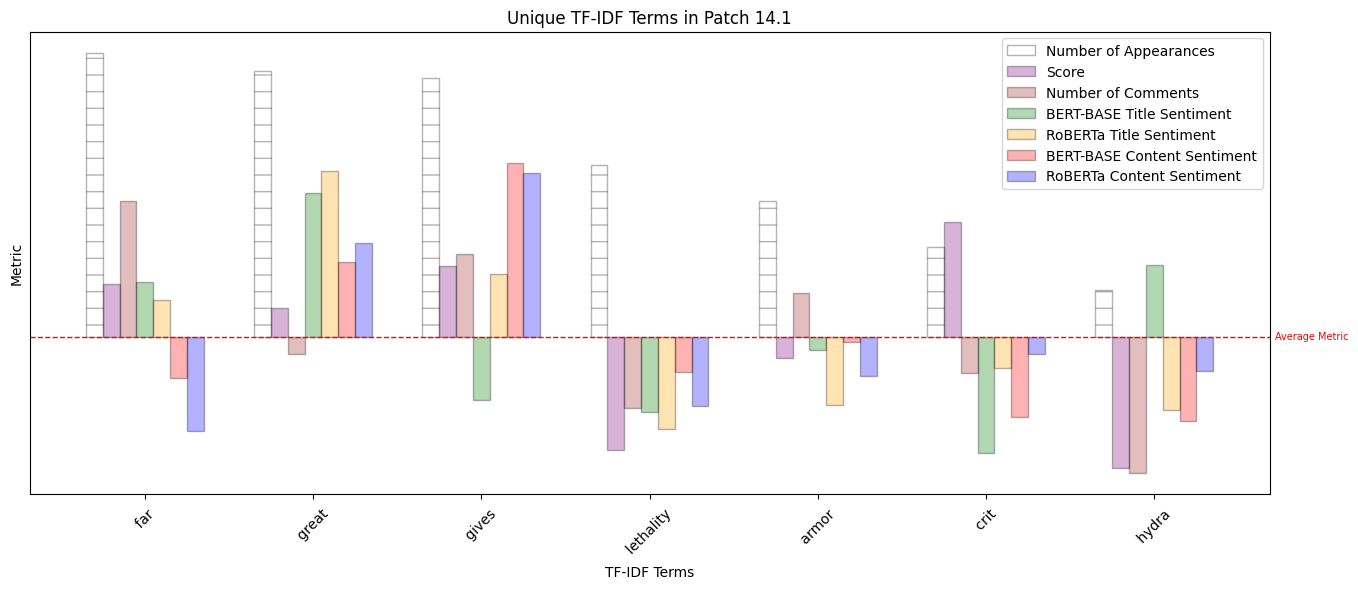

In [8]:
columns_to_normalize = ['Score', 'BERT-BASE Title Sentiment', 'RoBERTa Title Sentiment', 'BERT-BASE Content Sentiment', 'RoBERTa Content Sentiment', 
                        'Comment Count', 'Number of Appearances']
columns_to_offset = ['Number of Appearances']

plot_df.loc[:, columns_to_normalize] = plot_df[columns_to_normalize].apply(lambda x: (x - x.mean()) / x.std())
plot_df.loc[:, columns_to_offset] = plot_df[columns_to_offset].apply(lambda x: (x - x.min()) + 0.5)

plot_df = plot_df.copy()
plot_df.sort_values(by='Number of Appearances', ascending=False, inplace=True)
plot_df.reset_index(drop=True, inplace=True)

# Plotting
bar_width = 0.1

# Position of bars on x-axis
r1 = np.arange(len(plot_df['Unique Term']))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]
r6 = [x + bar_width for x in r5]
r7 = [x + bar_width for x in r6]

# Make the plot
plt.figure(figsize=(16, 6))  # Adjusting the figure size to fit all bars
plt.bar(r1, plot_df['Number of Appearances'], color='white', alpha=0.3, width=bar_width, edgecolor='black', hatch='-', label='Number of Appearances')
plt.bar(r2, plot_df['Score'], color='purple', alpha=0.3, width=bar_width, edgecolor='black', label='Score')
plt.bar(r3, plot_df['Comment Count'], color='brown', alpha=0.3, width=bar_width, edgecolor='black', label='Number of Comments')
plt.bar(r4, plot_df['BERT-BASE Title Sentiment'], color='green', alpha=0.3, width=bar_width, edgecolor='black', label='BERT-BASE Title Sentiment')
plt.bar(r5, plot_df['RoBERTa Title Sentiment'], color='orange', alpha=0.3, width=bar_width, edgecolor='black', label='RoBERTa Title Sentiment')
plt.bar(r6, plot_df['BERT-BASE Content Sentiment'], color='red', alpha=0.3, width=bar_width, edgecolor='black', label='BERT-BASE Content Sentiment')
plt.bar(r7, plot_df['RoBERTa Content Sentiment'], color='blue', alpha=0.3, width=bar_width, edgecolor='black', label='RoBERTa Content Sentiment')

# Add a dashed horizontal red line at y=0 across the entire plot
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.text(len(plot_df['Unique Term']) + 0.02, -0.05, 'Average Metric', color='red', fontsize=7, verticalalignment='bottom')

# Add xticks on the middle of the group bars
plt.xlabel('TF-IDF Terms')
plt.xticks([r + 3 * bar_width for r in range(len(plot_df['Unique Term']))], plot_df['Unique Term'])
plt.xticks(rotation=45)
plt.yticks([])

# Add labels and title
plt.ylabel('Metric')
plt.title('Unique TF-IDF Terms in Patch 14.1')

# Create legend & Show graphic
plt.legend()
plt.show()

##### Unique Terms in Patch 14.2

In [9]:
original_patch_term = unique_tfidf[unique_tfidf["Patch"] == 14.2]["Unique Terms"].tolist()[0].split(',')
compare_patch_terms = unique_tfidf[unique_tfidf["Patch"] == 14.1]["Unique Terms"].tolist()[0].split(',')
patch_terms = original_patch_term + compare_patch_terms
patch_terms = [s.replace(" ", "") for s in patch_terms]
patch_terms = [' ' + word + ' ' for word in patch_terms]

plot_df = terms_count[terms_count['Unique Term'].isin(patch_terms)]
plot_df.reset_index(drop=True, inplace=True)
plot_df[plot_df['Unique Term'] == " " + original_patch_term[0] + " "]

,Unique Term,Score,BERT-BASE Title Sentiment,RoBERTa Title Sentiment,BERT-BASE Content Sentiment,RoBERTa Content Sentiment,Comment Count,Number of Appearances
1,buff,26.210247,1.821555,0.948763,1.072438,0.473498,18.570671,566


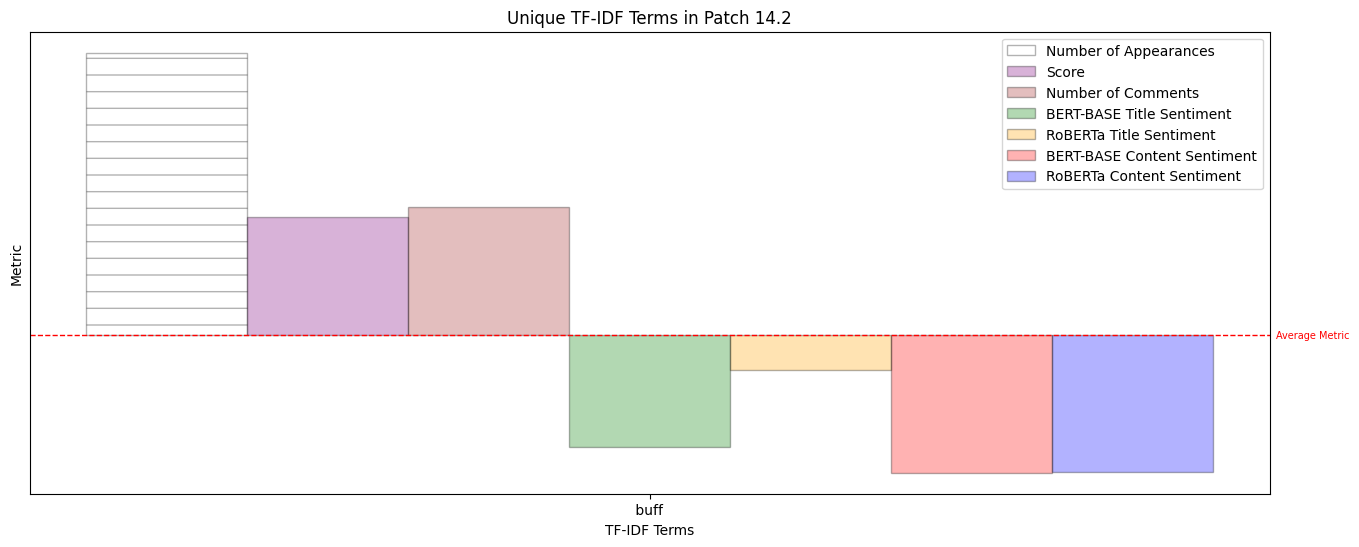

In [10]:
columns_to_normalize = ['Score', 'BERT-BASE Title Sentiment', 'RoBERTa Title Sentiment', 'BERT-BASE Content Sentiment', 'RoBERTa Content Sentiment', 
                        'Comment Count', 'Number of Appearances']
columns_to_offset = ['Number of Appearances']

plot_df.loc[:, columns_to_normalize] = plot_df[columns_to_normalize].apply(lambda x: (x - x.mean()) / x.std())
plot_df.loc[:, columns_to_offset] = plot_df[columns_to_offset].apply(lambda x: (x - x.min()) + 0.5)

plot_df = plot_df.copy()
plot_df = plot_df[plot_df['Unique Term'] == " " + original_patch_term[0] + " "]
plot_df.reset_index(drop=True, inplace=True)
plot_df

# Plotting
bar_width = 0.1

# Position of bars on x-axis
r1 = [0]
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]
r6 = [x + bar_width for x in r5]
r7 = [x + bar_width for x in r6]

# Make the plot
plt.figure(figsize=(16, 6))  # Adjusting the figure size to fit all bars
plt.bar(r1, plot_df['Number of Appearances'], color='white', alpha=0.3, width=bar_width, edgecolor='black', hatch='-', label='Number of Appearances')
plt.bar(r2, plot_df['Score'], color='purple', alpha=0.3, width=bar_width, edgecolor='black', label='Score')
plt.bar(r3, plot_df['Comment Count'], color='brown', alpha=0.3, width=bar_width, edgecolor='black', label='Number of Comments')
plt.bar(r4, plot_df['BERT-BASE Title Sentiment'], color='green', alpha=0.3, width=bar_width, edgecolor='black', label='BERT-BASE Title Sentiment')
plt.bar(r5, plot_df['RoBERTa Title Sentiment'], color='orange', alpha=0.3, width=bar_width, edgecolor='black', label='RoBERTa Title Sentiment')
plt.bar(r6, plot_df['BERT-BASE Content Sentiment'], color='red', alpha=0.3, width=bar_width, edgecolor='black', label='BERT-BASE Content Sentiment')
plt.bar(r7, plot_df['RoBERTa Content Sentiment'], color='blue', alpha=0.3, width=bar_width, edgecolor='black', label='RoBERTa Content Sentiment')

# Add a dashed horizontal red line at y=0 across the entire plot
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.text(0.689, -0.05, 'Average Metric', color='red', fontsize=7, verticalalignment='bottom')

# Add xticks on the middle of the group bars
plt.xlabel('TF-IDF Terms')
plt.xticks([r + 3 * bar_width for r in range(1)], plot_df['Unique Term'])
# plt.xticks(rotation=45)
plt.yticks([])

# Add labels and title
plt.ylabel('Metric')
plt.title('Unique TF-IDF Terms in Patch 14.2')

# Create legend & Show graphic
plt.legend()
plt.show()

##### Unique Terms in Patch 14.3

In [11]:
patch_terms = unique_tfidf[unique_tfidf["Patch"] == 14.3]["Unique Terms"].tolist()[0].split(',')
patch_terms = [s.replace(" ", "") for s in patch_terms]
patch_terms = [' ' + word + ' ' for word in patch_terms]

plot_df = terms_count[terms_count['Unique Term'].isin(patch_terms)]
plot_df.reset_index(drop=True, inplace=True)
plot_df

,Unique Term,Score,BERT-BASE Title Sentiment,RoBERTa Title Sentiment,BERT-BASE Content Sentiment,RoBERTa Content Sentiment,Comment Count,Number of Appearances
0,change,19.221713,1.977064,0.892966,1.412844,0.599388,15.314985,654
1,thanks,38.947368,2.538012,1.175439,1.309942,0.590643,18.567251,171
2,tips,8.416931,2.501587,0.987302,1.845503,0.797884,11.466667,945
3,ve,9.500000,2.375000,0.812500,0.750000,0.437500,23.687500,16


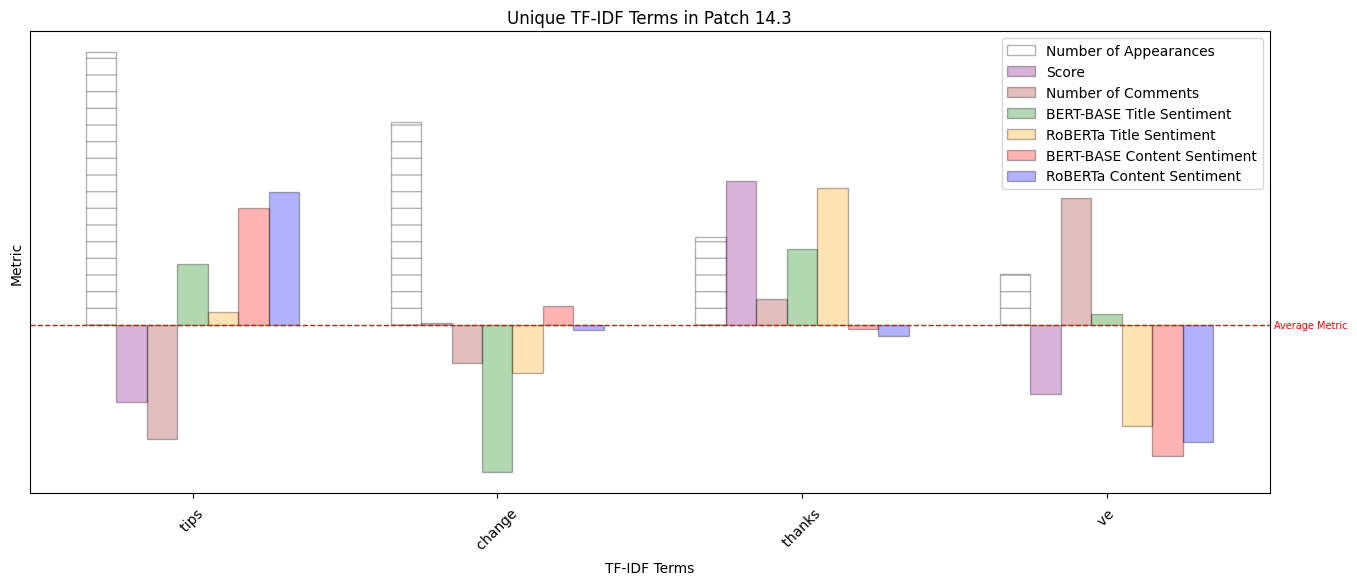

In [12]:
columns_to_normalize = ['Score', 'BERT-BASE Title Sentiment', 'RoBERTa Title Sentiment', 'BERT-BASE Content Sentiment', 'RoBERTa Content Sentiment', 
                        'Comment Count', 'Number of Appearances']
columns_to_offset = ['Number of Appearances']

plot_df.loc[:, columns_to_normalize] = plot_df[columns_to_normalize].apply(lambda x: (x - x.mean()) / x.std())
plot_df.loc[:, columns_to_offset] = plot_df[columns_to_offset].apply(lambda x: (x - x.min()) + 0.5)

plot_df = plot_df.copy()
plot_df.sort_values(by='Number of Appearances', ascending=False, inplace=True)
plot_df.reset_index(drop=True, inplace=True)

# Plotting
bar_width = 0.1

# Position of bars on x-axis
r1 = np.arange(len(plot_df['Unique Term']))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]
r6 = [x + bar_width for x in r5]
r7 = [x + bar_width for x in r6]

# Make the plot
plt.figure(figsize=(16, 6))  # Adjusting the figure size to fit all bars
plt.bar(r1, plot_df['Number of Appearances'], color='white', alpha=0.3, width=bar_width, edgecolor='black', hatch='-', label='Number of Appearances')
plt.bar(r2, plot_df['Score'], color='purple', alpha=0.3, width=bar_width, edgecolor='black', label='Score')
plt.bar(r3, plot_df['Comment Count'], color='brown', alpha=0.3, width=bar_width, edgecolor='black', label='Number of Comments')
plt.bar(r4, plot_df['BERT-BASE Title Sentiment'], color='green', alpha=0.3, width=bar_width, edgecolor='black', label='BERT-BASE Title Sentiment')
plt.bar(r5, plot_df['RoBERTa Title Sentiment'], color='orange', alpha=0.3, width=bar_width, edgecolor='black', label='RoBERTa Title Sentiment')
plt.bar(r6, plot_df['BERT-BASE Content Sentiment'], color='red', alpha=0.3, width=bar_width, edgecolor='black', label='BERT-BASE Content Sentiment')
plt.bar(r7, plot_df['RoBERTa Content Sentiment'], color='blue', alpha=0.3, width=bar_width, edgecolor='black', label='RoBERTa Content Sentiment')

# Add a dashed horizontal red line at y=0 across the entire plot
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.text(len(plot_df['Unique Term']) - 0.15, -0.05, 'Average Metric', color='red', fontsize=7, verticalalignment='bottom')

# Add xticks on the middle of the group bars
plt.xlabel('TF-IDF Terms')
plt.xticks([r + 3 * bar_width for r in range(len(plot_df['Unique Term']))], plot_df['Unique Term'])
plt.xticks(rotation=45)
plt.yticks([])

# Add labels and title
plt.ylabel('Metric')
plt.title('Unique TF-IDF Terms in Patch 14.3')

# Create legend & Show graphic
plt.legend()
plt.show()

##### Unique Terms in Patch 14.4

In [13]:
original_patch_term = unique_tfidf[unique_tfidf["Patch"] == 14.4]["Unique Terms"].tolist()[0].split(',')
compare_patch_terms = unique_tfidf[unique_tfidf["Patch"] == 14.3]["Unique Terms"].tolist()[0].split(',')
patch_terms = original_patch_term + compare_patch_terms
patch_terms = [s.replace(" ", "") for s in patch_terms]
patch_terms = [' ' + word + ' ' for word in patch_terms]

plot_df = terms_count[terms_count['Unique Term'].isin(patch_terms)]
plot_df.reset_index(drop=True, inplace=True)
plot_df[plot_df['Unique Term'] == " " + original_patch_term[0] + " "]

,Unique Term,Score,BERT-BASE Title Sentiment,RoBERTa Title Sentiment,BERT-BASE Content Sentiment,RoBERTa Content Sentiment,Comment Count,Number of Appearances
1,patch,28.076355,1.871921,0.966749,0.979064,0.461823,18.960591,812


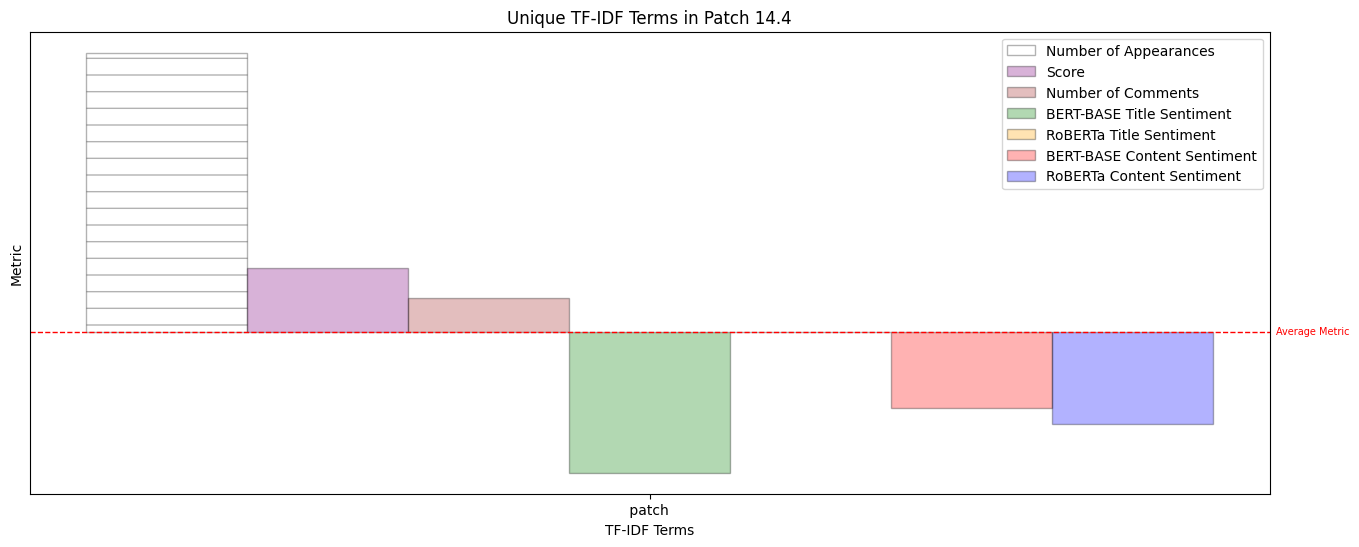

In [14]:
columns_to_normalize = ['Score', 'BERT-BASE Title Sentiment', 'RoBERTa Title Sentiment', 'BERT-BASE Content Sentiment', 'RoBERTa Content Sentiment', 
                        'Comment Count', 'Number of Appearances']
columns_to_offset = ['Number of Appearances']

plot_df.loc[:, columns_to_normalize] = plot_df[columns_to_normalize].apply(lambda x: (x - x.mean()) / x.std())
plot_df.loc[:, columns_to_offset] = plot_df[columns_to_offset].apply(lambda x: (x - x.min()) + 0.5)

plot_df = plot_df.copy()
plot_df = plot_df[plot_df['Unique Term'] == " " + original_patch_term[0] + " "]
plot_df.reset_index(drop=True, inplace=True)
plot_df

# Plotting
bar_width = 0.1

# Position of bars on x-axis
r1 = [0]
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]
r6 = [x + bar_width for x in r5]
r7 = [x + bar_width for x in r6]

# Make the plot
plt.figure(figsize=(16, 6))  # Adjusting the figure size to fit all bars
plt.bar(r1, plot_df['Number of Appearances'], color='white', alpha=0.3, width=bar_width, edgecolor='black', hatch='-', label='Number of Appearances')
plt.bar(r2, plot_df['Score'], color='purple', alpha=0.3, width=bar_width, edgecolor='black', label='Score')
plt.bar(r3, plot_df['Comment Count'], color='brown', alpha=0.3, width=bar_width, edgecolor='black', label='Number of Comments')
plt.bar(r4, plot_df['BERT-BASE Title Sentiment'], color='green', alpha=0.3, width=bar_width, edgecolor='black', label='BERT-BASE Title Sentiment')
plt.bar(r5, plot_df['RoBERTa Title Sentiment'], color='orange', alpha=0.3, width=bar_width, edgecolor='black', label='RoBERTa Title Sentiment')
plt.bar(r6, plot_df['BERT-BASE Content Sentiment'], color='red', alpha=0.3, width=bar_width, edgecolor='black', label='BERT-BASE Content Sentiment')
plt.bar(r7, plot_df['RoBERTa Content Sentiment'], color='blue', alpha=0.3, width=bar_width, edgecolor='black', label='RoBERTa Content Sentiment')

# Add a dashed horizontal red line at y=0 across the entire plot
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.text(0.689, -0.04, 'Average Metric', color='red', fontsize=7, verticalalignment='bottom')

# Add xticks on the middle of the group bars
plt.xlabel('TF-IDF Terms')
plt.xticks([r + 3 * bar_width for r in range(1)], plot_df['Unique Term'])
# plt.xticks(rotation=45)
plt.yticks([])

# Add labels and title
plt.ylabel('Metric')
plt.title('Unique TF-IDF Terms in Patch 14.4')

# Create legend & Show graphic
plt.legend()
plt.show()

##### Unique Terms in Patch 14.5

In [15]:
patch_terms = unique_tfidf[unique_tfidf["Patch"] == 14.5]["Unique Terms"].tolist()[0].split(',')
patch_terms = [s.replace(" ", "") for s in patch_terms]
patch_terms = [' ' + word + ' ' for word in patch_terms]

plot_df = terms_count[terms_count['Unique Term'].isin(patch_terms)]
plot_df.reset_index(drop=True, inplace=True)
plot_df

,Unique Term,Score,BERT-BASE Title Sentiment,RoBERTa Title Sentiment,BERT-BASE Content Sentiment,RoBERTa Content Sentiment,Comment Count,Number of Appearances
0,eq,13.833333,1.250000,0.833333,1.250000,0.416667,6.916667,12
1,eqeq,93.400000,1.800000,0.400000,0.800000,0.200000,13.400000,5
2,looking,11.011331,2.312559,0.983947,1.932011,0.973560,11.237960,1059
3,tell,15.353033,2.335925,1.018663,1.362364,0.608087,14.206843,643


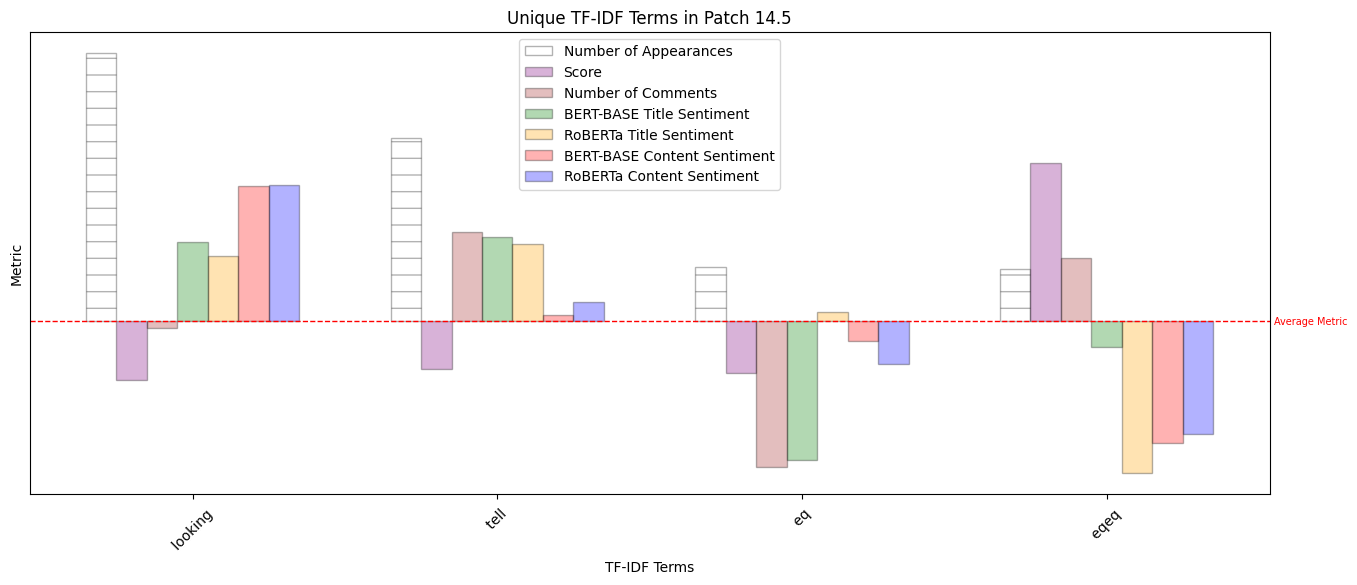

In [16]:
columns_to_normalize = ['Score', 'BERT-BASE Title Sentiment', 'RoBERTa Title Sentiment', 'BERT-BASE Content Sentiment', 'RoBERTa Content Sentiment', 
                        'Comment Count', 'Number of Appearances']
columns_to_offset = ['Number of Appearances']

plot_df.loc[:, columns_to_normalize] = plot_df[columns_to_normalize].apply(lambda x: (x - x.mean()) / x.std())
plot_df.loc[:, columns_to_offset] = plot_df[columns_to_offset].apply(lambda x: (x - x.min()) + 0.5)

plot_df = plot_df.copy()
plot_df.sort_values(by='Number of Appearances', ascending=False, inplace=True)
plot_df.reset_index(drop=True, inplace=True)

# Plotting
bar_width = 0.1

# Position of bars on x-axis
r1 = np.arange(len(plot_df['Unique Term']))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]
r6 = [x + bar_width for x in r5]
r7 = [x + bar_width for x in r6]

# Make the plot
plt.figure(figsize=(16, 6))  # Adjusting the figure size to fit all bars
plt.bar(r1, plot_df['Number of Appearances'], color='white', alpha=0.3, width=bar_width, edgecolor='black', hatch='-', label='Number of Appearances')
plt.bar(r2, plot_df['Score'], color='purple', alpha=0.3, width=bar_width, edgecolor='black', label='Score')
plt.bar(r3, plot_df['Comment Count'], color='brown', alpha=0.3, width=bar_width, edgecolor='black', label='Number of Comments')
plt.bar(r4, plot_df['BERT-BASE Title Sentiment'], color='green', alpha=0.3, width=bar_width, edgecolor='black', label='BERT-BASE Title Sentiment')
plt.bar(r5, plot_df['RoBERTa Title Sentiment'], color='orange', alpha=0.3, width=bar_width, edgecolor='black', label='RoBERTa Title Sentiment')
plt.bar(r6, plot_df['BERT-BASE Content Sentiment'], color='red', alpha=0.3, width=bar_width, edgecolor='black', label='BERT-BASE Content Sentiment')
plt.bar(r7, plot_df['RoBERTa Content Sentiment'], color='blue', alpha=0.3, width=bar_width, edgecolor='black', label='RoBERTa Content Sentiment')

# Add a dashed horizontal red line at y=0 across the entire plot
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.text(len(plot_df['Unique Term']) - 0.15, -0.05, 'Average Metric', color='red', fontsize=7, verticalalignment='bottom')

# Add xticks on the middle of the group bars
plt.xlabel('TF-IDF Terms')
plt.xticks([r + 3 * bar_width for r in range(len(plot_df['Unique Term']))], plot_df['Unique Term'])
plt.xticks(rotation=45)
plt.yticks([])

# Add labels and title
plt.ylabel('Metric')
plt.title('Unique TF-IDF Terms in Patch 14.5')

# Create legend & Show graphic
plt.legend()
plt.show()

##### Unique Terms in Patch 14.6

In [17]:
original_patch_term = unique_tfidf[unique_tfidf["Patch"] == 14.6]["Unique Terms"].tolist()[0].split(',')
compare_patch_terms = unique_tfidf[unique_tfidf["Patch"] == 14.5]["Unique Terms"].tolist()[0].split(',')
patch_terms = original_patch_term + compare_patch_terms
patch_terms = [s.replace(" ", "") for s in patch_terms]
patch_terms = [' ' + word + ' ' for word in patch_terms]

plot_df = terms_count[terms_count['Unique Term'].isin(patch_terms)]
plot_df.reset_index(drop=True, inplace=True)
plot_df[plot_df['Unique Term'] == " " + original_patch_term[0] + " "]

,Unique Term,Score,BERT-BASE Title Sentiment,RoBERTa Title Sentiment,BERT-BASE Content Sentiment,RoBERTa Content Sentiment,Comment Count,Number of Appearances
3,shield,15.173077,2.004274,0.933761,1.611111,0.803419,14.942308,468


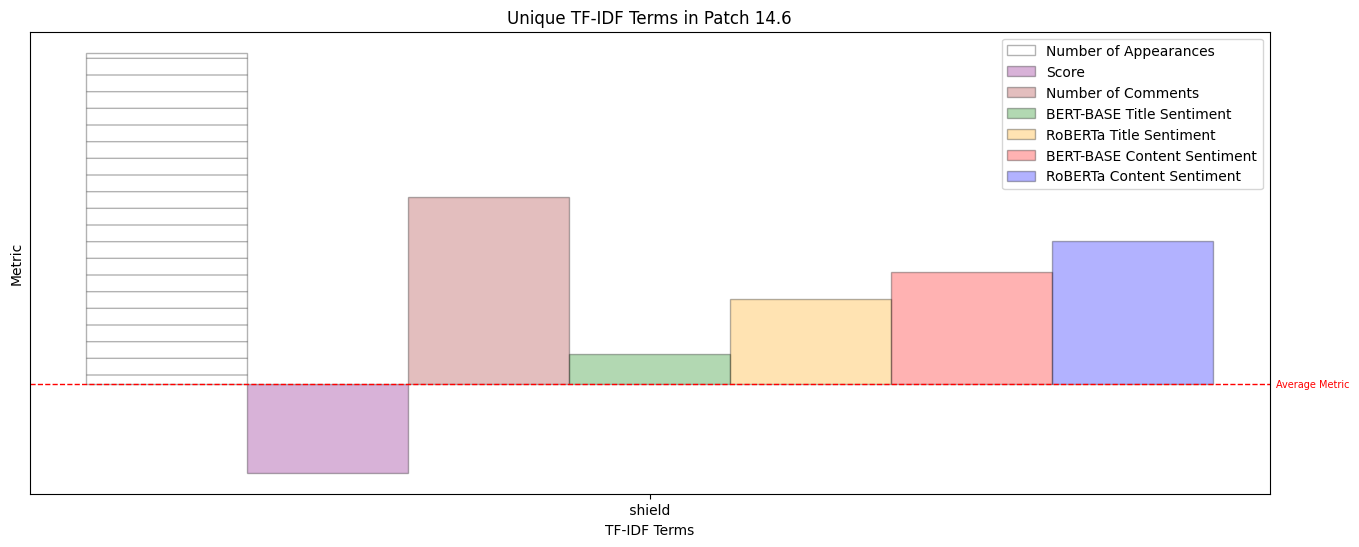

In [18]:
columns_to_normalize = ['Score', 'BERT-BASE Title Sentiment', 'RoBERTa Title Sentiment', 'BERT-BASE Content Sentiment', 'RoBERTa Content Sentiment', 
                        'Comment Count', 'Number of Appearances']
columns_to_offset = ['Number of Appearances']

plot_df.loc[:, columns_to_normalize] = plot_df[columns_to_normalize].apply(lambda x: (x - x.mean()) / x.std())
plot_df.loc[:, columns_to_offset] = plot_df[columns_to_offset].apply(lambda x: (x - x.min()) + 0.5)

plot_df = plot_df.copy()
plot_df = plot_df[plot_df['Unique Term'] == " " + original_patch_term[0] + " "]
plot_df.reset_index(drop=True, inplace=True)
plot_df

# Plotting
bar_width = 0.1

# Position of bars on x-axis
r1 = [0]
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]
r6 = [x + bar_width for x in r5]
r7 = [x + bar_width for x in r6]

# Make the plot
plt.figure(figsize=(16, 6))  # Adjusting the figure size to fit all bars
plt.bar(r1, plot_df['Number of Appearances'], color='white', alpha=0.3, width=bar_width, edgecolor='black', hatch='-', label='Number of Appearances')
plt.bar(r2, plot_df['Score'], color='purple', alpha=0.3, width=bar_width, edgecolor='black', label='Score')
plt.bar(r3, plot_df['Comment Count'], color='brown', alpha=0.3, width=bar_width, edgecolor='black', label='Number of Comments')
plt.bar(r4, plot_df['BERT-BASE Title Sentiment'], color='green', alpha=0.3, width=bar_width, edgecolor='black', label='BERT-BASE Title Sentiment')
plt.bar(r5, plot_df['RoBERTa Title Sentiment'], color='orange', alpha=0.3, width=bar_width, edgecolor='black', label='RoBERTa Title Sentiment')
plt.bar(r6, plot_df['BERT-BASE Content Sentiment'], color='red', alpha=0.3, width=bar_width, edgecolor='black', label='BERT-BASE Content Sentiment')
plt.bar(r7, plot_df['RoBERTa Content Sentiment'], color='blue', alpha=0.3, width=bar_width, edgecolor='black', label='RoBERTa Content Sentiment')

# Add a dashed horizontal red line at y=0 across the entire plot
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.text(0.689, -0.025, 'Average Metric', color='red', fontsize=7, verticalalignment='bottom')

# Add xticks on the middle of the group bars
plt.xlabel('TF-IDF Terms')
plt.xticks([r + 3 * bar_width for r in range(1)], plot_df['Unique Term'])
# plt.xticks(rotation=45)
plt.yticks([])

# Add labels and title
plt.ylabel('Metric')
plt.title('Unique TF-IDF Terms in Patch 14.6')

# Create legend & Show graphic
plt.legend()
plt.show()

##### Unique Terms in Patch 14.7

In [19]:
patch_terms = unique_tfidf[unique_tfidf["Patch"] == 14.7]["Unique Terms"].tolist()[0].split(',')
patch_terms = [s.replace(" ", "") for s in patch_terms]
patch_terms = [' ' + word + ' ' for word in patch_terms]

plot_df = terms_count[terms_count['Unique Term'].isin(patch_terms)]
plot_df.reset_index(drop=True, inplace=True)
plot_df

,Unique Term,Score,BERT-BASE Title Sentiment,RoBERTa Title Sentiment,BERT-BASE Content Sentiment,RoBERTa Content Sentiment,Comment Count,Number of Appearances
0,old,30.123223,2.193128,0.931280,1.311611,0.575829,19.212085,844
1,slow,37.206960,2.049451,0.904762,1.690476,0.730769,18.272894,546
2,wave,13.690756,2.201681,0.900840,1.648739,0.625210,15.460504,595


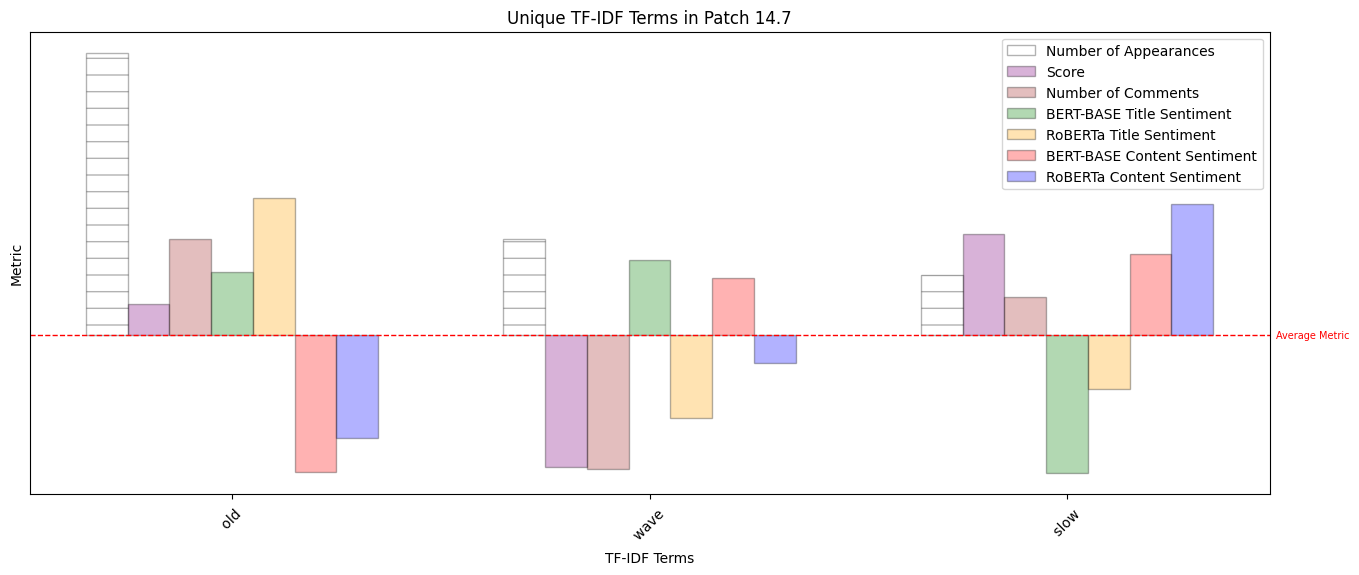

In [20]:
columns_to_normalize = ['Score', 'BERT-BASE Title Sentiment', 'RoBERTa Title Sentiment', 'BERT-BASE Content Sentiment', 'RoBERTa Content Sentiment', 
                        'Comment Count', 'Number of Appearances']
columns_to_offset = ['Number of Appearances']

plot_df.loc[:, columns_to_normalize] = plot_df[columns_to_normalize].apply(lambda x: (x - x.mean()) / x.std())
plot_df.loc[:, columns_to_offset] = plot_df[columns_to_offset].apply(lambda x: (x - x.min()) + 0.5)

plot_df = plot_df.copy()
plot_df.sort_values(by='Number of Appearances', ascending=False, inplace=True)
plot_df.reset_index(drop=True, inplace=True)

# Plotting
bar_width = 0.1

# Position of bars on x-axis
r1 = np.arange(len(plot_df['Unique Term']))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]
r6 = [x + bar_width for x in r5]
r7 = [x + bar_width for x in r6]

# Make the plot
plt.figure(figsize=(16, 6))  # Adjusting the figure size to fit all bars
plt.bar(r1, plot_df['Number of Appearances'], color='white', alpha=0.3, width=bar_width, edgecolor='black', hatch='-', label='Number of Appearances')
plt.bar(r2, plot_df['Score'], color='purple', alpha=0.3, width=bar_width, edgecolor='black', label='Score')
plt.bar(r3, plot_df['Comment Count'], color='brown', alpha=0.3, width=bar_width, edgecolor='black', label='Number of Comments')
plt.bar(r4, plot_df['BERT-BASE Title Sentiment'], color='green', alpha=0.3, width=bar_width, edgecolor='black', label='BERT-BASE Title Sentiment')
plt.bar(r5, plot_df['RoBERTa Title Sentiment'], color='orange', alpha=0.3, width=bar_width, edgecolor='black', label='RoBERTa Title Sentiment')
plt.bar(r6, plot_df['BERT-BASE Content Sentiment'], color='red', alpha=0.3, width=bar_width, edgecolor='black', label='BERT-BASE Content Sentiment')
plt.bar(r7, plot_df['RoBERTa Content Sentiment'], color='blue', alpha=0.3, width=bar_width, edgecolor='black', label='RoBERTa Content Sentiment')

# Add a dashed horizontal red line at y=0 across the entire plot
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.text(len(plot_df['Unique Term']) - 0.2, -0.045, 'Average Metric', color='red', fontsize=7, verticalalignment='bottom')

# Add xticks on the middle of the group bars
plt.xlabel('TF-IDF Terms')
plt.xticks([r + 3 * bar_width for r in range(len(plot_df['Unique Term']))], plot_df['Unique Term'])
plt.xticks(rotation=45)
plt.yticks([])

# Add labels and title
plt.ylabel('Metric')
plt.title('Unique TF-IDF Terms in Patch 14.7')

# Create legend & Show graphic
plt.legend()
plt.show()

##### Unique Terms in Patch 14.8

In [21]:
patch_terms = unique_tfidf[unique_tfidf["Patch"] == 14.8]["Unique Terms"].tolist()[0].split(',')
patch_terms = [s.replace(" ", "") for s in patch_terms]
patch_terms = [' ' + word + ' ' for word in patch_terms]

plot_df = terms_count[terms_count['Unique Term'].isin(patch_terms)]
plot_df.reset_index(drop=True, inplace=True)
plot_df

,Unique Term,Score,BERT-BASE Title Sentiment,RoBERTa Title Sentiment,BERT-BASE Content Sentiment,RoBERTa Content Sentiment,Comment Count,Number of Appearances
0,bot,26.249300,2.057423,0.855742,1.431373,0.648459,18.296919,714
1,instead,21.835703,2.062401,0.924171,1.664297,0.802528,18.192733,1266
2,wanted,23.139845,2.304287,1.009136,1.515109,0.761771,14.728742,1423


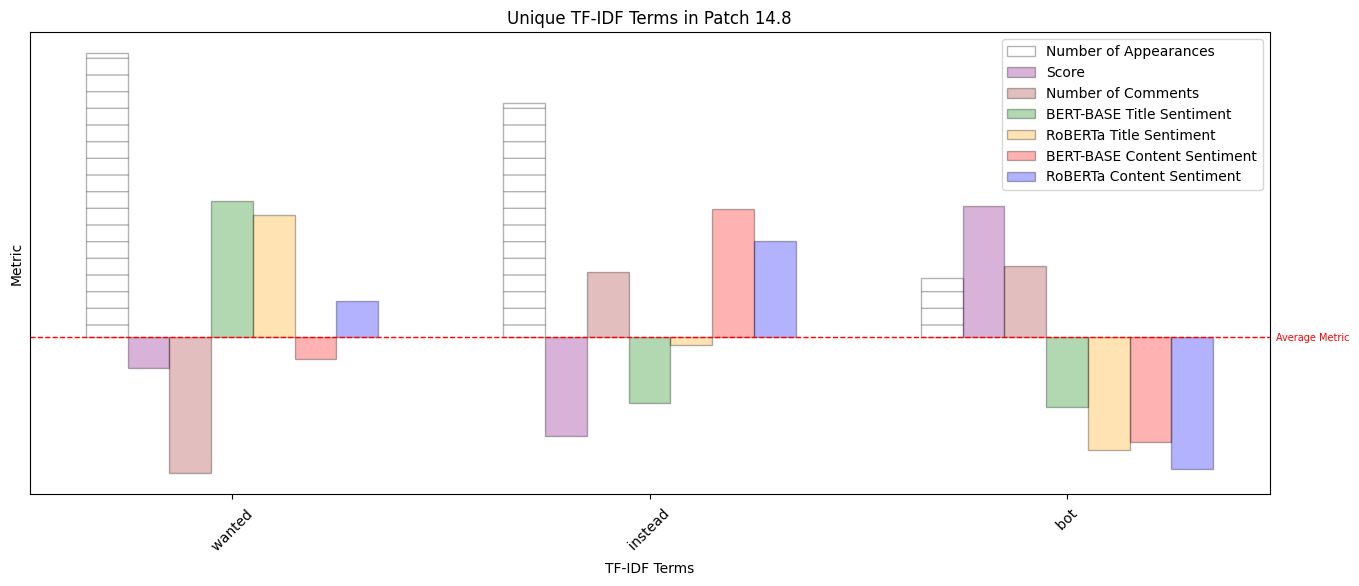

In [22]:
columns_to_normalize = ['Score', 'BERT-BASE Title Sentiment', 'RoBERTa Title Sentiment', 'BERT-BASE Content Sentiment', 'RoBERTa Content Sentiment', 
                        'Comment Count', 'Number of Appearances']
columns_to_offset = ['Number of Appearances']

plot_df.loc[:, columns_to_normalize] = plot_df[columns_to_normalize].apply(lambda x: (x - x.mean()) / x.std())
plot_df.loc[:, columns_to_offset] = plot_df[columns_to_offset].apply(lambda x: (x - x.min()) + 0.5)

plot_df = plot_df.copy()
plot_df.sort_values(by='Number of Appearances', ascending=False, inplace=True)
plot_df.reset_index(drop=True, inplace=True)

# Plotting
bar_width = 0.1

# Position of bars on x-axis
r1 = np.arange(len(plot_df['Unique Term']))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]
r6 = [x + bar_width for x in r5]
r7 = [x + bar_width for x in r6]

# Make the plot
plt.figure(figsize=(16, 6))  # Adjusting the figure size to fit all bars
plt.bar(r1, plot_df['Number of Appearances'], color='white', alpha=0.3, width=bar_width, edgecolor='black', hatch='-', label='Number of Appearances')
plt.bar(r2, plot_df['Score'], color='purple', alpha=0.3, width=bar_width, edgecolor='black', label='Score')
plt.bar(r3, plot_df['Comment Count'], color='brown', alpha=0.3, width=bar_width, edgecolor='black', label='Number of Comments')
plt.bar(r4, plot_df['BERT-BASE Title Sentiment'], color='green', alpha=0.3, width=bar_width, edgecolor='black', label='BERT-BASE Title Sentiment')
plt.bar(r5, plot_df['RoBERTa Title Sentiment'], color='orange', alpha=0.3, width=bar_width, edgecolor='black', label='RoBERTa Title Sentiment')
plt.bar(r6, plot_df['BERT-BASE Content Sentiment'], color='red', alpha=0.3, width=bar_width, edgecolor='black', label='BERT-BASE Content Sentiment')
plt.bar(r7, plot_df['RoBERTa Content Sentiment'], color='blue', alpha=0.3, width=bar_width, edgecolor='black', label='RoBERTa Content Sentiment')

# Add a dashed horizontal red line at y=0 across the entire plot
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.text(len(plot_df['Unique Term']) - 0.2, -0.05, 'Average Metric', color='red', fontsize=7, verticalalignment='bottom')

# Add xticks on the middle of the group bars
plt.xlabel('TF-IDF Terms')
plt.xticks([r + 3 * bar_width for r in range(len(plot_df['Unique Term']))], plot_df['Unique Term'])
plt.xticks(rotation=45)
plt.yticks([])

# Add labels and title
plt.ylabel('Metric')
plt.title('Unique TF-IDF Terms in Patch 14.8')

# Create legend & Show graphic
plt.legend()
plt.show()